## Cálculo para Ciencias de datos : Tarea 1 🌎

Para el desarrollo de esta tarea se utilizan explícitamente a lo largo del notebook casi todos los código de ejemplo entregados en canvas para poder realizar el análisis de las distancias, los plots y la búsqueda de los vecinos más cercanos. 

Nota de ejecucción : Para leer los archivos correctamente, estos deben encontrarse en el mismo directorio del notebook. 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import math 

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
print(df_empirical_Holocene) # Se imprimen los dataframes para conocer mejor los datos 
print(df_empirical_LGM)

        lon    lat       dep   log_dep  log_dep_norm
0      1.37  78.87  3.999995  0.602059      0.185196
1    -61.00  77.00  0.040000 -1.397941     -1.669137
2    -42.32  75.10  0.008000 -2.096911     -2.317199
3     -6.72  74.58  3.100001  0.491362      0.082561
4    -37.63  72.58  0.009000 -2.045758     -2.269772
..      ...    ...       ...       ...           ...
392    0.00 -75.00  0.002000 -2.698970     -2.875408
393  123.35 -75.10  0.000400 -3.397941     -3.523470
394  107.00 -78.00  0.000700 -3.154901     -3.298132
395  107.00 -78.00  0.000400 -3.397941     -3.523470
396 -120.00 -80.00  0.003000 -2.522879     -2.712142

[397 rows x 5 columns]
        lon    lat        dep   log_dep  log_dep_norm
0    -61.00  77.00   0.080000 -1.096911     -2.662962
1    -42.32  75.10   0.170000 -0.769551     -2.317613
2    -37.63  72.58   0.326000 -0.486782     -2.019304
3    129.42  71.77  81.999907  1.913813      0.513214
4    -27.00  71.00   0.120000 -0.920818     -2.477192
..      ...    .

In [4]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [5]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='magma',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


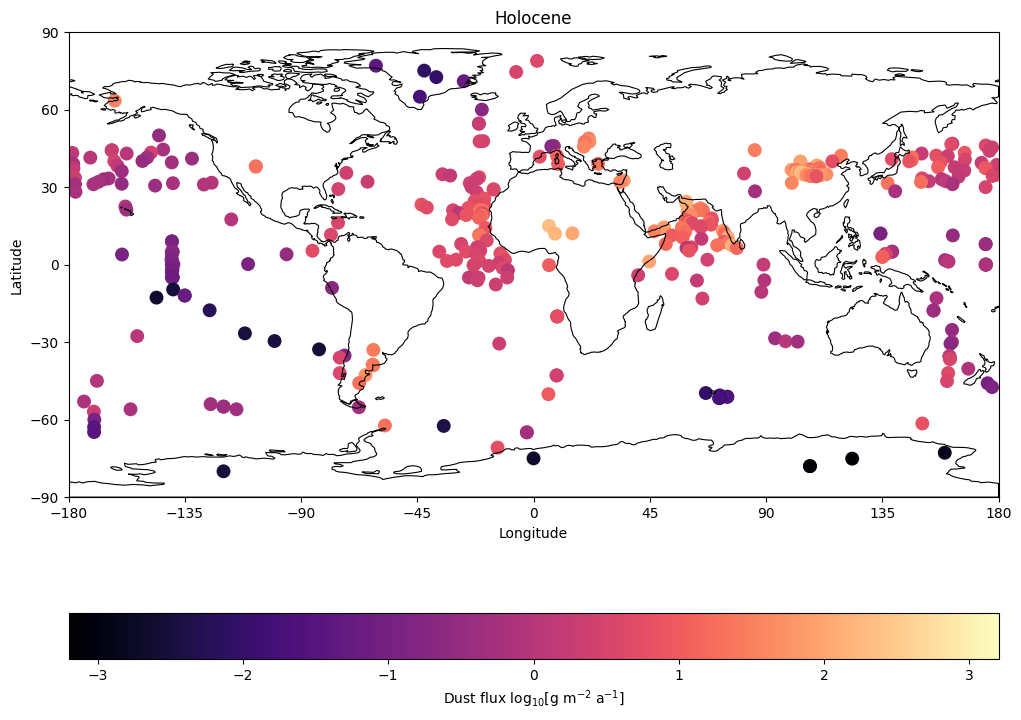

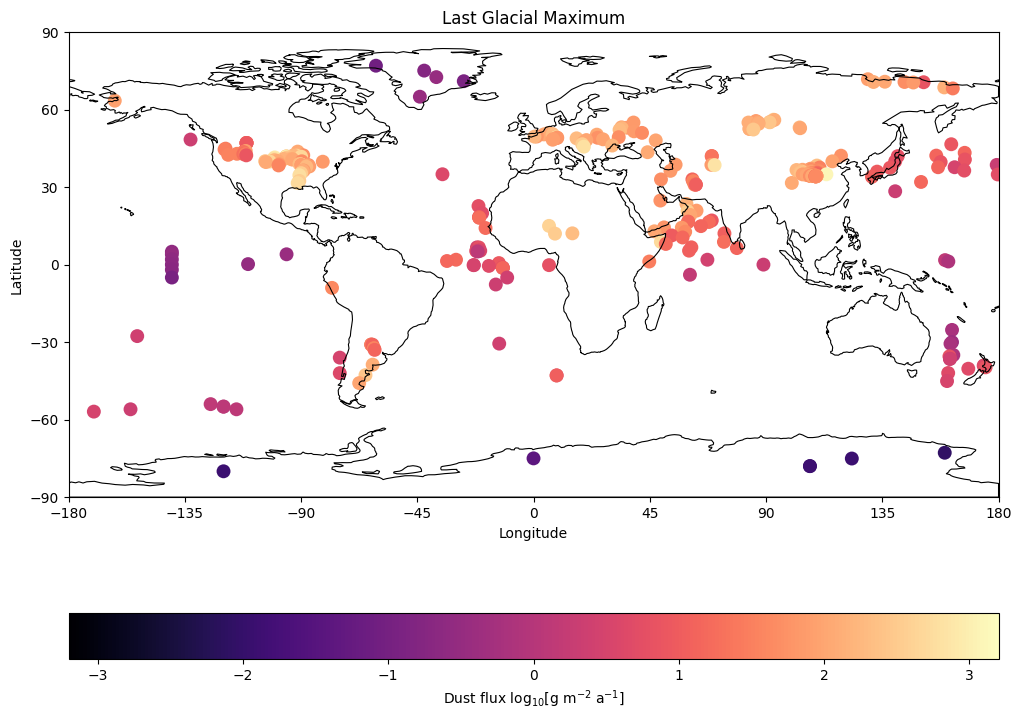

In [6]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [7]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

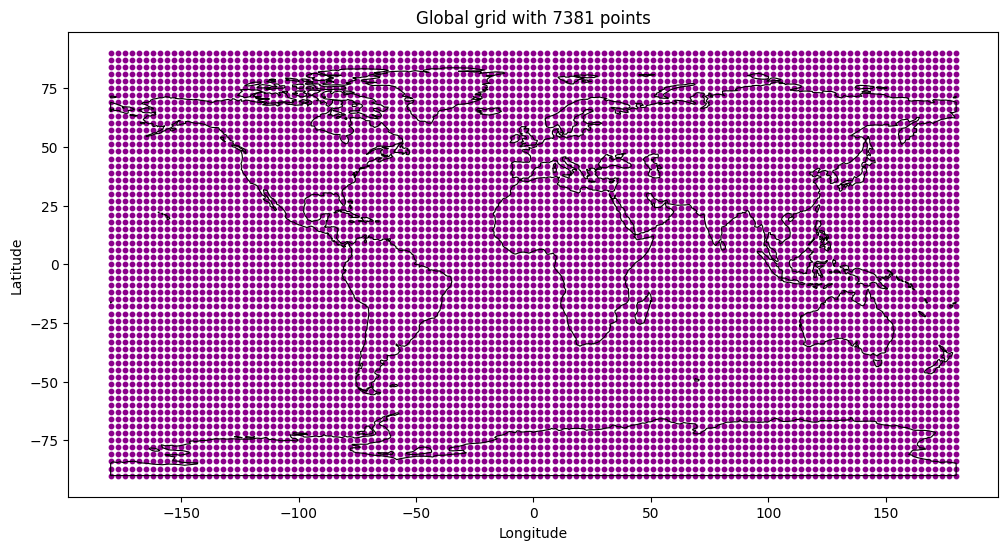

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='darkmagenta', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [9]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [10]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    earth_radius = 6371.0 #source = Chat gpt
    longitud_rad_x = math.radians(x[0])
    longitud_rad_y = math.radians(y[0])
    latitud_rad_x = math.radians(x[1])
    latitud_rad_y = math.radians(y[1])
    geodesic_distance = earth_radius * np.arccos(np.sin(latitud_rad_x) * np.sin(latitud_rad_y) + np.cos(latitud_rad_x) * np.cos(latitud_rad_y) * np.cos(longitud_rad_y - longitud_rad_x)) 
                                                                                                                  
    return geodesic_distance

In [11]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [12]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [13]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

In [14]:
#Se almacena una copia de los datos de estimación con distancia euclidiana para que no se sobreescriban en el df
est_euclidian_hol = df_global_grid["est_hol"].copy() 
est_euclidian_lgm = df_global_grid["est_lgm"].copy()

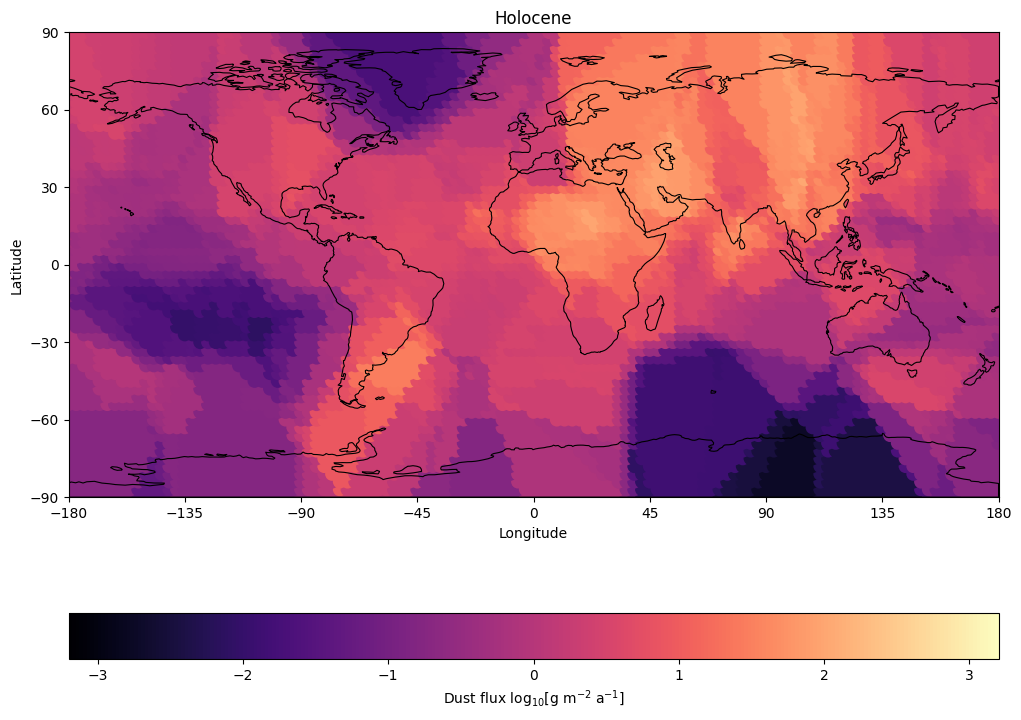

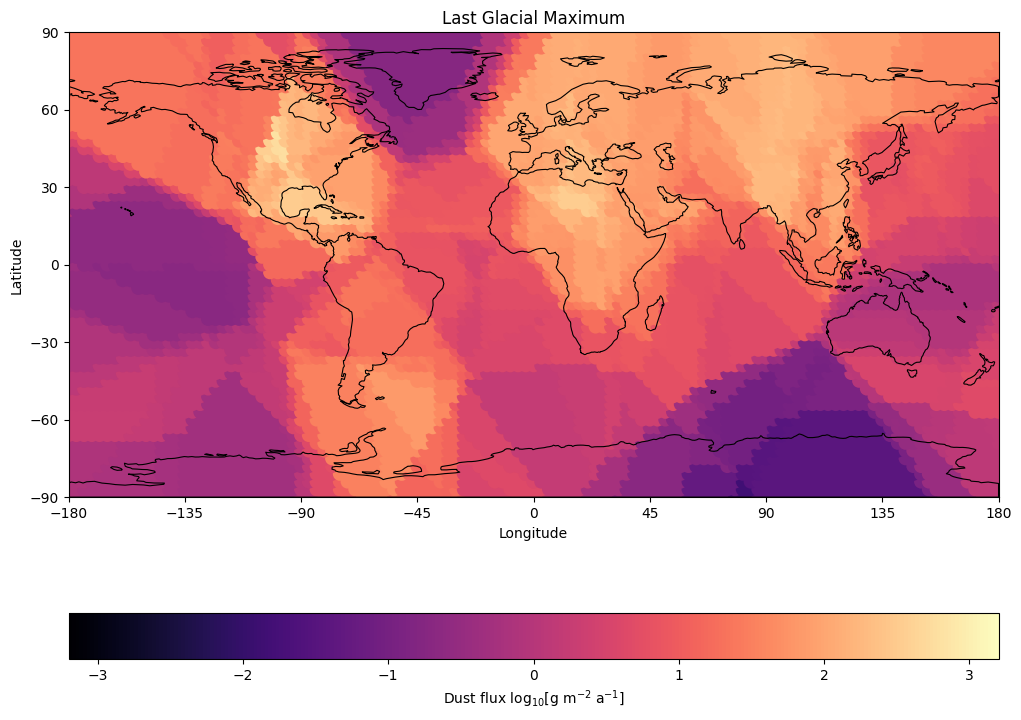

In [15]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [ ]:

estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():                                                                     
    point_for_estimation = (row["lon"], row["lat"])                                              
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

In [ ]:
est_geodesic_hol = df_global_grid["est_hol"].copy()  #Guardar valores y que no sean sobreescritos 
est_geodesic_lgm = df_global_grid["est_lgm"].copy()

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [21]:
df_global_grid["dif_est_hol"] = np.abs(est_euclidian_hol - est_geodesic_hol) #Pregunte a gpt mejor opción si con absolute value o no
df_global_grid["dif_est_lgm"] = np.abs(est_euclidian_lgm - est_geodesic_hol)

In [22]:
df_global_grid_dif = df_global_grid.drop(columns=['est_hol', 'est_lgm']) #Chat gpt para .drop

In [28]:
df_analisis_grid = pd.concat([est_euclidian_hol, est_geodesic_hol,df_global_grid["dif_est_hol"], est_euclidian_lgm, est_geodesic_lgm, df_global_grid["dif_est_lgm"]], axis = 1)
print(df_analisis_grid)
df_analisis_grid.describe()

       est_hol   est_hol  dif_est_hol   est_lgm   est_lgm  dif_est_lgm
0    -0.736623 -3.034526     2.297903 -0.111441 -1.804872     2.923085
1    -0.736623 -3.034526     2.297903 -0.111441 -1.804872     2.923085
2    -0.736623 -3.034526     2.297903 -0.175193 -1.804872     2.859333
3    -0.736623 -3.034526     2.297903 -0.175193 -1.804872     2.859333
4    -0.740268 -3.034526     2.294258 -0.175193 -1.804872     2.859333
...        ...       ...          ...       ...       ...          ...
7376  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7377  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7378  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7379  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7380  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901

[7381 rows x 6 columns]


,est_hol,est_hol,dif_est_hol,est_lgm,est_lgm,dif_est_lgm
count,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000
mean,0.014575,-0.295567,0.405867,0.736400,0.410496,1.073777
std,1.044539,1.205997,0.672228,0.989173,1.230231,0.883988
min,-2.730721,-3.107162,0.000000,-1.834825,-1.937201,0.000124
25%,-0.716035,-0.889438,0.000000,-0.026745,-0.509371,0.352262
50%,0.174538,-0.166646,0.049196,0.829739,0.614881,0.836326
75%,0.642920,0.523679,0.517005,1.522036,1.391107,1.614331
max,2.022372,2.006798,3.958761,2.815395,2.755189,4.556562


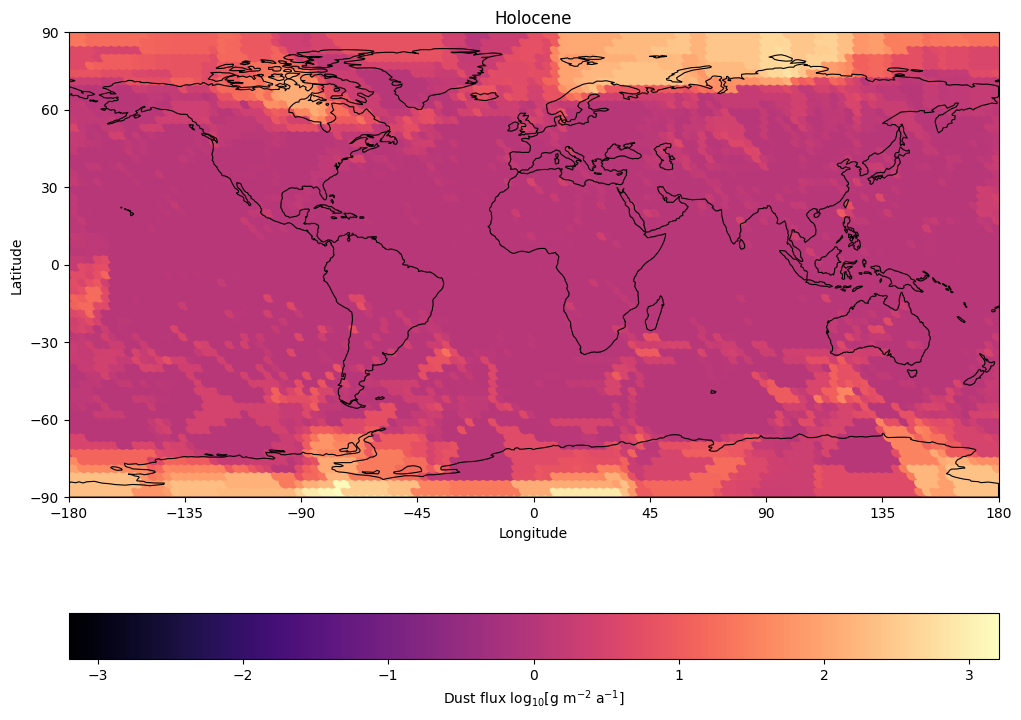

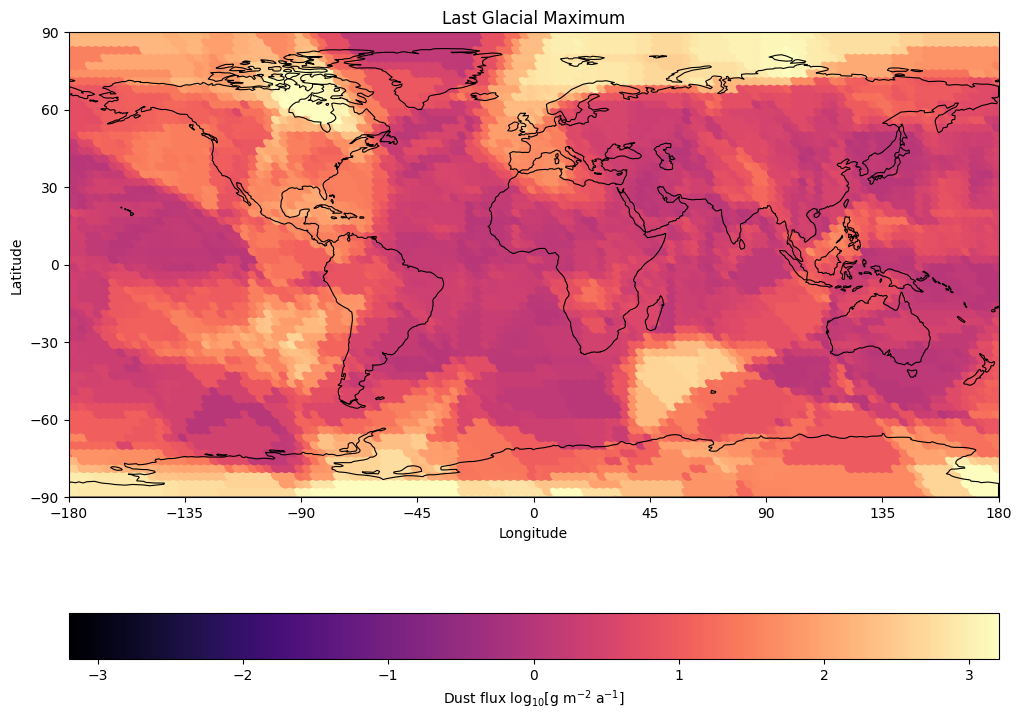

In [25]:
plot_dust_deposition_map(df=df_global_grid_dif,
                         title='Holocene',
                         name_to_save='DIFERENCE_ESTIMATION_MAP_HOLOCENE',
                         label_str='dif_est_hol')

plot_dust_deposition_map(df=df_global_grid_dif,
                         title='Last Glacial Maximum',
                         name_to_save='DIFERENCE_ESTIMATION_MAP_LGM',
                         label_str='dif_est_lgm')

### ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?
Las diferencias pueden deberse primero a los datos utilizados y la densidad/cantidad de estos por cada región, esto cambiaría bastante que tanta distancia hay entre un puntos, y también que tan cerca se pueden encontrar los vecinos. Ya que la falta de registros modificaría la existencia real de ciertos vecinos o cercanias entre lugares. 
Por otro lado, también pueden haber diferencias por las características geográficas de estas partes del mundo en particular, seguramente hay variación en los datos considerando si hay lugares que tengan mayor flujo por ser desiertos, tener corrientes marinas y otros. En la última Era Glacial parece haberse acrecentado la diferencia en el continente americano, seguramente en conexión con el cambio climático o por la razones antes mencionadas. 
También debe considerarse que hay una notable diferencia en las áreas de los polos en ambos mapas, esto podría suceder por la forma en que se contruye el modelo de división de latitud y longitud, considerando que en los polos convergen los meridianos, se ven afectadas las medidas de las coordenadas y por ende la distancia geodésica (que considera el componente es esferidad) 

### ¿Cuál método es más fidedigno para los polos?
Considerando que en los polos convergen los meridianos y cambía la concepción de longitud que hay porque las distancias se distorcionan respecto a territorios más hacia el centro del globo, es que utilizaría la distancia geodésica por la relevancia que tiene la curvatura en generar los cambios en las distancias. Considerando que comparativamente no se comportarían igual que en lugares donde las latitudes y longitudes tiene la definición gradial más uniforme en terminos de la división de la tierra. Todo esto considerando que las mediciones se hacen un plano de unidades longitud y latitud.   

Además en la era del holoceno la mayor diferencia se nota en los polos y en la era glacial también ocurre lo mismo en algunas zonas polares, se identifica porque tiene el color más claro. Lo que indicaría alta diferencia en las estimaciónes hechas por diferentes distancias, que podría deberse (no hay una causa asegurada) a la distorción en los polos. Si se ve particularmente en los mapas, los de la distnacia eucliana tienen muy poca marcación de flujo respecto de los que muestra la distancia geodésica.

### ¿Cuál método es más fidedigno en longitud 180° 
También se recomendaría el uso de la distancia geodésica, considerando que si bien no existe la distorición por la convergencia de los meridianos aún así se realizan los cálculos sobre una figura que no es originalmente plana sino que geoide/esférica, por ende los márgenes de error al usar la distancia euclidiana podrían ser mayores, ya que la medición de latitud y longitus considera la figura de la tierra a diferencia de cálculos en planos 2d comunes. Pero aún así se mira la división lat-long en sistema de plano, por lo que ambas distancias tienen alteración. 

Aterrizando lo anterior a lo mostrado por el mapa de la diferencia de estimaciones, se puede notar que en el holoceno no hay mayor variación en las estimaciones (hay un color morado cercano a los valores centro/0) por lo que usar una u otra distancia no parecería generar demaciado cambio si se trata solo de coordenadas en la longitud 180° y no en los polos. Sin embargo en la última era glacial ya comienzan a haber una mayor diferencia en la estimación dentro de la longitud 180°, sobretodo en la parte del continente americano. Por lo que, se recomendaría la distancia geodésica para descartar que hayan problemas con la distorción de valores producto de la cualidad esférica de la tierra. 

### ¿Cuál son las diferencias entre el Holoceno y la última era glacial ?

Si analizamos el mapa de la diferencia de estimaciones, se puede notar que del Holoceno a la última era glacial las partes en la longitud 180° (no polos) dejaron de ser zonas tan bajas en flujo de polvo y comenzaron a existir ciertas zonas en algunos continentes con alta variación en flujo; como ocurrió con partes de cercanas al oeste de america del sur, zonas cercanas al sur de África y también en América del norte. 


Si vemos individualmente los mapas de las distancias, se nota lo siguiente; 
1. Mapas distancia Geodésica:
   1. El flujo en el polo sur del holoceno respecto al de LGM dejó de ser tan oscura (valores negativos) y lo mismo sucede con las zonas más cercanas a los polos en América del norte, la zona del océano pacífico que está al oeste de América del sur y partes cercanas al sur de Africa en el océano Índico
   2. En practicamente todos continentes en la última Era Glacial comienzan a haber en gran parte de su superficie un alza en el flujo de polvo, los colores comeinzan a ser mucho más claro indicando un aumento.
   3. En general en la parte del oceano también en la última Era Glacial en su mayoría hay colores mucho más claros que indican un aumento en el flujo de polvo.

2. Mapas distancia euclidiana:
   1. En la última era glacial en la superficie de los contienentes hay un aumento en el flujo de polvo, sobretodo en algunas partes cercanas al sur de Africa y America del norte.
   2. Las regiones que tenían en el Holoceno un color muy oscuro (flujo negativo de polvo), siendo estas lo que en su mayoría es Groelandia y la Antártica más al este, en la última era Glacial toman un color mucho más claro, mostrando un valor positivo en el flujo de polvo

### ¿Cómo elegir el número de vecinos cercanos?
La elección debe guiarse princialmente por el objetivo que se quiere lograr con el clustering pero también por la cantidad de datos, considerando que una mayor cantidad de datos implica que la revisión es mucho más extensa y la compactación de los clusters se hace podría hacer mucho más compleja. 
Por otro lado, se podría tener en cuenta de si aumentar o no el número de vecinos cercanos permite disminuir la diferencia entre estimaciones con distintas distancias, pero debería analizarse si realmente existe un resultado que muestre algo así.

Un método que permite elegir un número de forma más objetiva es la técnica de la validación cruzada, este permite dividir y trabajar los datos en múliples escenarios evaluando con parámetros matemáticos el rendimiento en distintos K que se seleccionen. 

Si bien existen técnicas no "arbitrarias" de selección de vecinos también se puede considerar una elección según el contexto, viendo en la exploración de datos los outliers si es que afectan demasiado a la selección, el total de datos existentes y si una división en cierta cantidad de vecinos es lo óptimo para el análisis proporcionalmente hablando, entre otras cosas. 

#### Utilización de chat gpt:
Lo útilicé para entender:
1. Cómo funcionaba la búsqueda de vecinos cercanos y cómo variaba según los argumentos que se movían (distancia)
2. Cómo funcionan los meridianos y las longitudes/latitudes en los polos respecto al resto de la esfera 
3. Cómo podría influir la distancia euclidiana en partes más centro del plano (variación numérica)
4. Chequeo doble de la formúla que construí de distancia euclidiana (no realizó ningún cambio original a la fórmula, yo la seguí directamente del enunciado) 
5. Comandos de numpy y diferencias entre merge/concat 
6. Significado de la barra de valores de flujo de polvo en los gráficos 
7. En base a qué figura se construyó la distancia geodésica y la euclidiana
8. Información y contexto sobre la última era glacial y el holoceno, para asociar los cambios en los mapas
9. Comando en math para transformación a radianes
10. Aumento del k y valores matemáticos afectados, pasos de la validación cruzada y contexto